<a href="https://colab.research.google.com/github/WxTan000/AI_Class_Ugrad_Pub/blob/main/wht7vk_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

filename = r"cali_housing.csv"

# Your code goes here for this section, make sure you also include the output to answer the above questions.
housing_data = pd.read_csv(filename)

housing_data

# Your code goes here for this section.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


As we can see, the data contains 20640 cases and 10 features. There appear to be no missing values. 

For the purposes of this assignment, we will be discarding the qualitative feature and go strictly on the quantitative features. We believe that the latitude and longitude can suffice for the qualitative variable. 

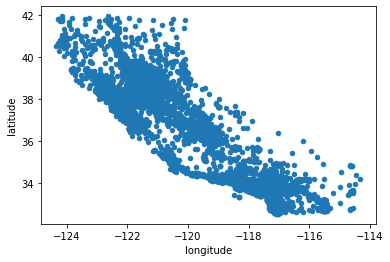

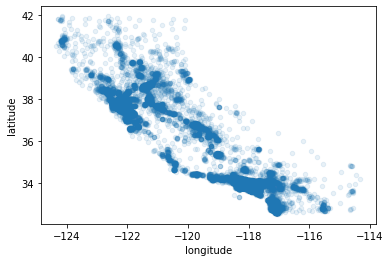

In [ ]:
housing_data.plot(kind='scatter', x='longitude', y='latitude')
housing_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

We are greeted with a similar distribution of data to that seen in one of the first Colab examples. When we set alpha to 0.1 to make data points more transparent (and thus make clustering related to opacity) we can see that there may be a distinction between northern and southern California. It may be possible to generate two clusters as required by the assignment. 

We'll now begin preparing the data for processing.

In [ ]:
num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

#num_attribs = ['longitude', 'latitude']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

X = full_pipeline.fit_transform(housing_data)
X = X.tolist();

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
import math;
import random;

MANHATTAN = 13;
EUCLIDEAN = 127;
CHEBYSHEV = 191; #Chebyshev is just another name for Sup Distance - it just has the same amount of characters so I couldn't resist.
SUP = CHEBYSHEV;

def minkowski_dist(x, y, TYPE): #Minkowski distance formula given two vectors (as lists). I know it's inefficient, but it's the simplest to understand.
  runningSum = 0;
  if (TYPE == MANHATTAN):
    for i in range(0, len(x)):
      runningSum = runningSum + abs(x[i] - y[i]);
    return runningSum;
  if (TYPE == EUCLIDEAN):
    for i in range(0, len(x)):
      runningSum = runningSum + (x[i] - y[i]) ** 2;
    return math.sqrt(runningSum);
  if (TYPE == CHEBYSHEV):
    runningMax = 0;
    for i in range(0, len(x)):
      diff = abs(x[i] - y[i]);
      if (diff > runningMax):
        runningMax = diff;
    return runningMax;

def convergenceCondition(centroids, oldCentroids, type, tolerance=0.05): #Detects if the change in centroids is small enough to claim convergence and finish the run.
  for i in range(0, len(centroids)):
    if (minkowski_dist(centroids[i], oldCentroids[i], type) > tolerance):
      return False;
  return True;

def get_centroid(data): #Pries out a centroid given a list of vectors.
  return np.mean(data, axis=0).tolist();



def generate_clusters(data, clusterCount, centers, type): #Given a list of centers, iterates through the entire list and assigns each vector to a cluster.
  clusters = [];
  for i in range(0, len(centers)):
    clusters.append([]);

  for vector in data:
    closestCenter = 0;
    minDist = math.inf;
    for i in range(0, len(centers)):
      dist = minkowski_dist(vector, centers[i], type);
      if (dist < minDist):
        minDist = dist;
        closestCenter = i;
    clusters[closestCenter].append(vector);
    #clusters[closestCenter].append(vector);
  return clusters;

#K-Means implementation here. Picks the starting set of centroids randomly (naive approach), then repeatedly generates clusters and new centroids until convergence.
def k_means(data, clusters=2, type=MANHATTAN, tolerance=0.05):
  centers = [];
  centersOld = [];
  clusters_list = [];

  for i in range(0, clusters):
    random_index = random.randint(0, len(data));
    centers.append(data[random_index])
    #print(centers[i]);
    centersOld.append(data[random.randint(0, len(data))])
  
  clusters_list = generate_clusters(data, clusters, centers, type);

  while (convergenceCondition(centers, centersOld, type, tolerance) == False):
    centersOld = centers.copy();
    
    for i in range(0, len(clusters_list)):
      centers[i] = get_centroid(clusters_list[i]);
    clusters_list = generate_clusters(data, clusters, centers, type);
    #for i in range(len(clusters_list)):
      #print("Iteration ", counter, ", center ", i+1, ": ", len(clusters_list[i]))

  return centers, clusters_list;

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


Cluster 1 :
SSE (Cumulative):  48129135168565.055
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.468288  35.703356           27.980277  2487.843271      528.335678   
std     1.988162   2.217344           12.257092  2079.167878      412.973699   

       population  households  median_income  median_house_value  
mean  1452.102557  488.895996       3.244509        149690.76300  
std   1150.526916  373.313125       1.222806         56199.21679  

Cluster 2 : 
SSE (Cumulative):  37855922001247.09
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.853853  35.431547           30.486462  3050.205563      560.663106   
std     2.019212   1.875051           13.291391  2397.991230      436.029137   

       population  households  median_income  median_house_value  
mean  1350.876404  529.361208       5.625055       367021.157672  
std   1076.842077  405.077715       2.314462        83468.132194  


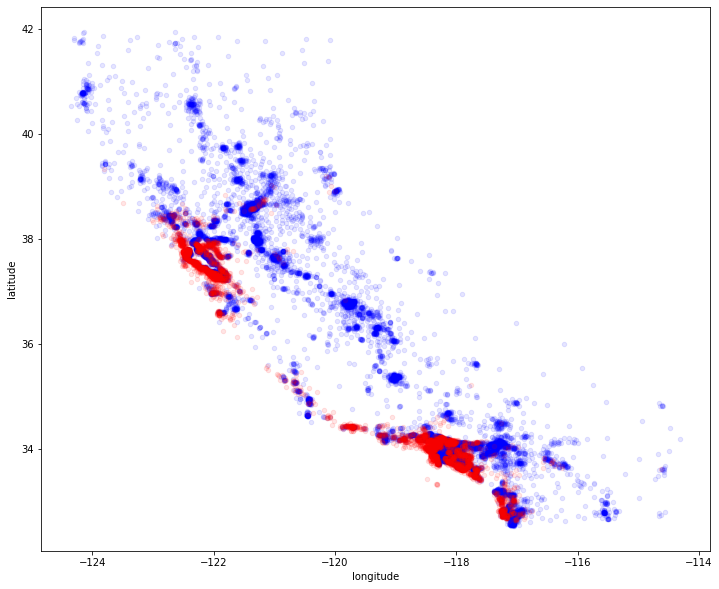

In [ ]:
# Your code goes here
import matplotlib.pyplot as plt;

# Your paragraph goes here for this section
colors = ['b', 'r', 'y', 'g', 'c', 'm', '#FFAB00', '#DE00FF', '#909090', '#C65600']

def cumulative_SSE(centroid, cluster):
  cumSum = 0;
  for i in range(len(cluster)):
    for j in range(len(centroid)):
      cumSum = cumSum + (cluster[i][j] - centroid[j]) ** 2;
  return cumSum;

random.seed(42)
pd.set_option('display.max_columns', 9)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 2, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.1, figsize=(12, 10))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.1)


#centroids
#rebuiltDF

As can be seen above, when accounting for all quantitative features, we were not exactly able to split California into north and south portions. Instead, we split California into areas where housing is more expensive and where housing is cheaper. 

This is because we, again, used all quantitative features which included income and median value - which factored into the clustering. If were were to purely use latitude and longitude, we would be able to split California into geographically distinct halves as asked of us in the assignment. 

What our clustering process gave us were two distinct parts of California: the expensive, urbanized areas where income and housing cost are both high (San Fran, Los Angeles, San Diego, etc. and their associated suburbs) and the more rural areas where income and housing cost are both comparatively lower. The analysis of the data prove this as well - the income and house value are significantly higher in the second cluster than in the first. 

We will see if more distinctive clusters appear when increasing the number of clusters. Since the map can become quite dense, we may have to increase the size of the graph.


Cluster 1 :
SSE (Cumulative):  13699118150321.053
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.478800  35.938892           27.755450  2352.976127      508.080497   
std     2.016978   2.324591           12.335727  1953.765073      393.951631   

       population  households  median_income  median_house_value  
mean  1422.572359  465.656999       2.866709       117417.519582  
std   1150.788162  353.852979       1.045829        36689.356898  

Cluster 2 : 
SSE (Cumulative):  12777331647330.803
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.845519  35.396711           31.988846  3005.766730      535.283301   
std     1.995957   1.848127           13.265137  2369.613882      411.872953   

       population  households  median_income  median_house_value  
mean  1250.002868  503.891013       6.236817       423919.874124  
std   1005.710581  382.012105       2.618518        63766.473290  

Cluster 3 : 


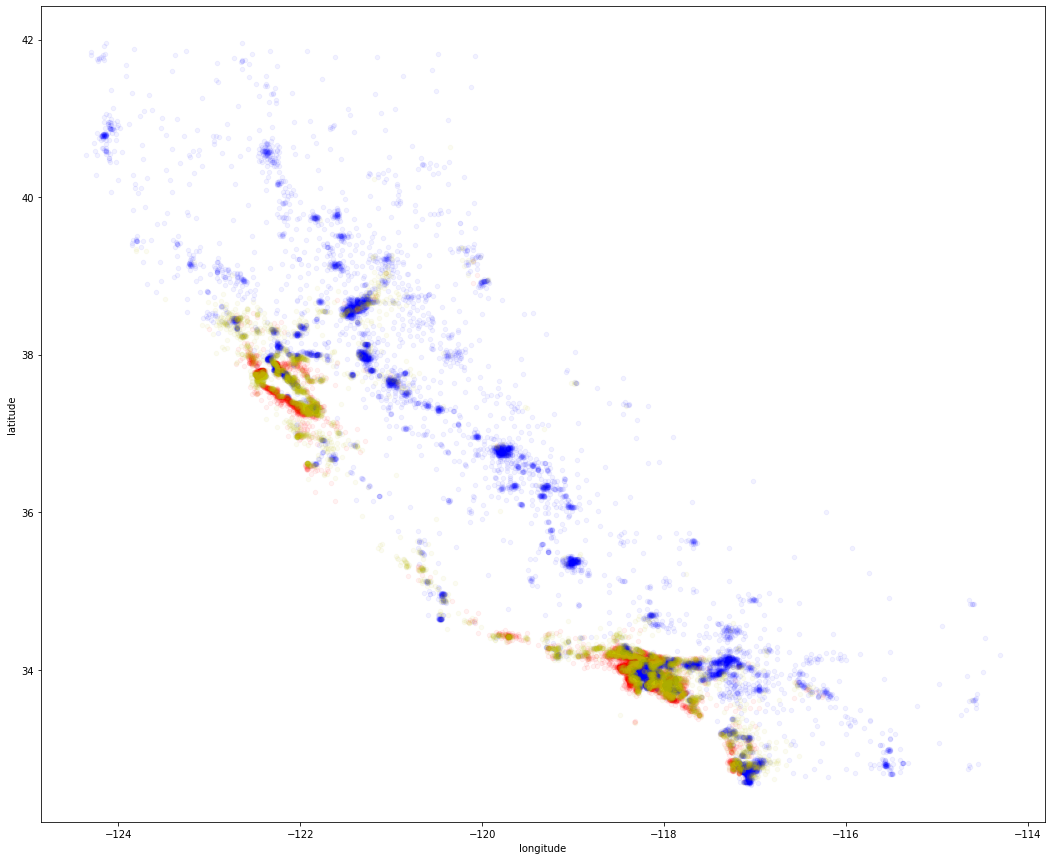

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 3, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  6397258619537.481
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.299361  35.190616           28.111705  2642.321085      554.201497   
std     1.902320   1.958802           12.119348  2232.569368      434.872780   

       population  households  median_income  median_house_value  
mean  1532.880812  520.020844       3.749829       190994.681988  
std   1151.825951  392.689155       1.159850        29124.749925  

Cluster 2 : 
SSE (Cumulative):  3228880288918.4214
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.820195  35.357419           32.948797  2992.701485      522.420891   
std     1.993820   1.838645           13.206953  2181.649176      380.534074   

       population  households  median_income  median_house_value  
mean  1192.268817  490.264209       6.807861       466267.058372  
std    881.225840  351.252580       2.885351        40599.691692  

Cluster 3 : 
S

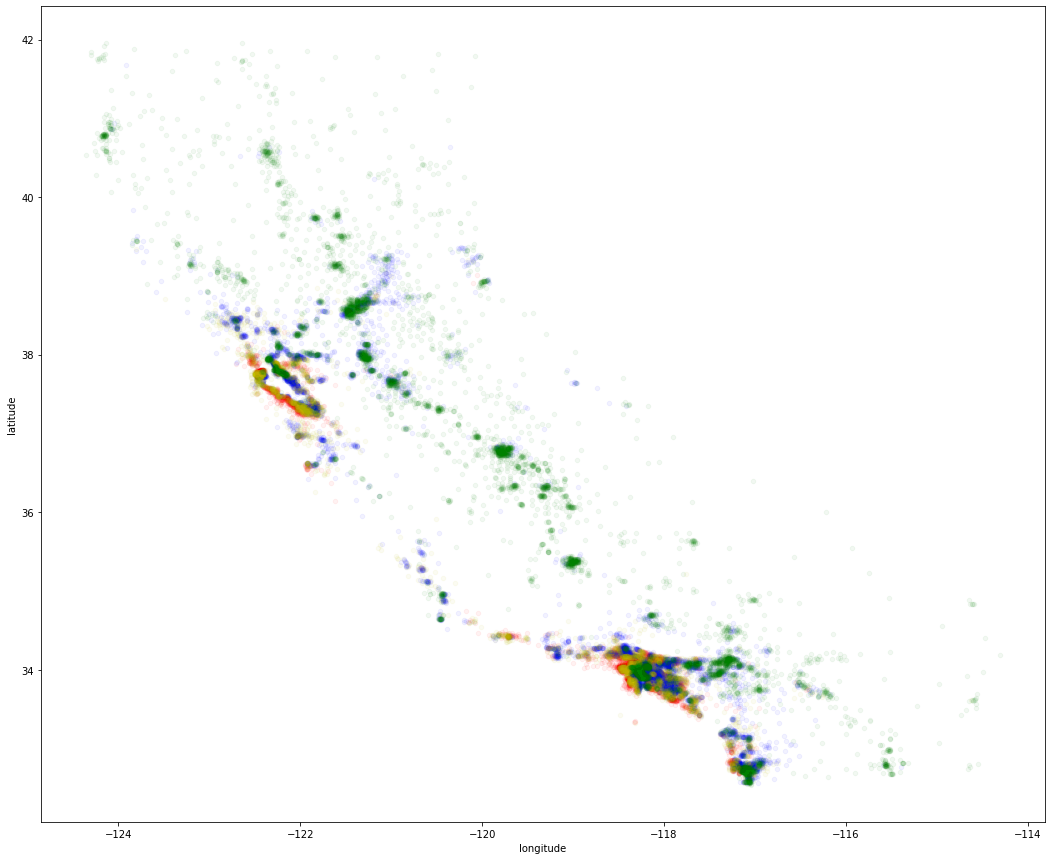

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 4, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  2950192152835.801
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.663400  35.355024           28.430549  2924.207033      582.590330   
std     1.994843   1.894436           12.422028  2348.835565      452.408164   

       population  households  median_income  median_house_value  
mean  1507.148352  551.282857       4.345511       244974.065934  
std   1139.325657  414.927973       1.316373        25324.776836  

Cluster 2 : 
SSE (Cumulative):  1340709403106.761
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.751300  35.289672           33.289164  2958.387616      514.448916   
std     1.973332   1.815319           13.145359  2153.174802      382.428338   

       population  households  median_income  median_house_value  
mean  1160.009288  480.679876       7.015804       480401.030960  
std    845.243581  350.910463       3.015593        28723.767055  

Cluster 3 : 
SS

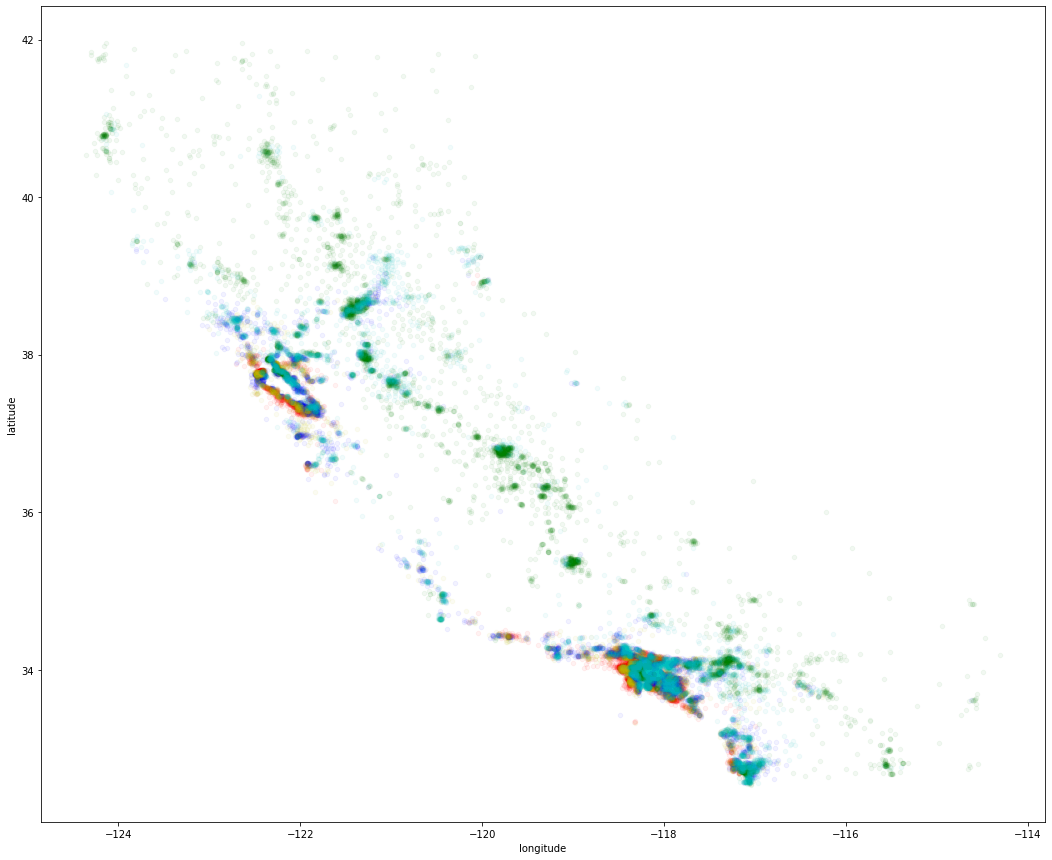

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 5, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  1310891307663.789
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.846095  35.483554           28.288435  3039.365986      589.325510   
std     2.053620   1.920810           12.784489  2384.002716      457.736812   

       population  households  median_income  median_house_value  
mean  1494.823810  557.561224       4.619318       269245.952381  
std   1132.592335  420.253564       1.385581        20944.702563  

Cluster 2 : 
SSE (Cumulative):  999000080731.1813
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.734948  35.275039           33.343546  2959.634941      514.610821   
std     1.969442   1.812783           13.085148  2161.139046      384.625566   

       population  households  median_income  median_house_value  
mean  1155.361147  480.401565       7.080270       483740.003259  
std    845.088324  352.441279       3.045823        25416.656392  

Cluster 3 : 
SS

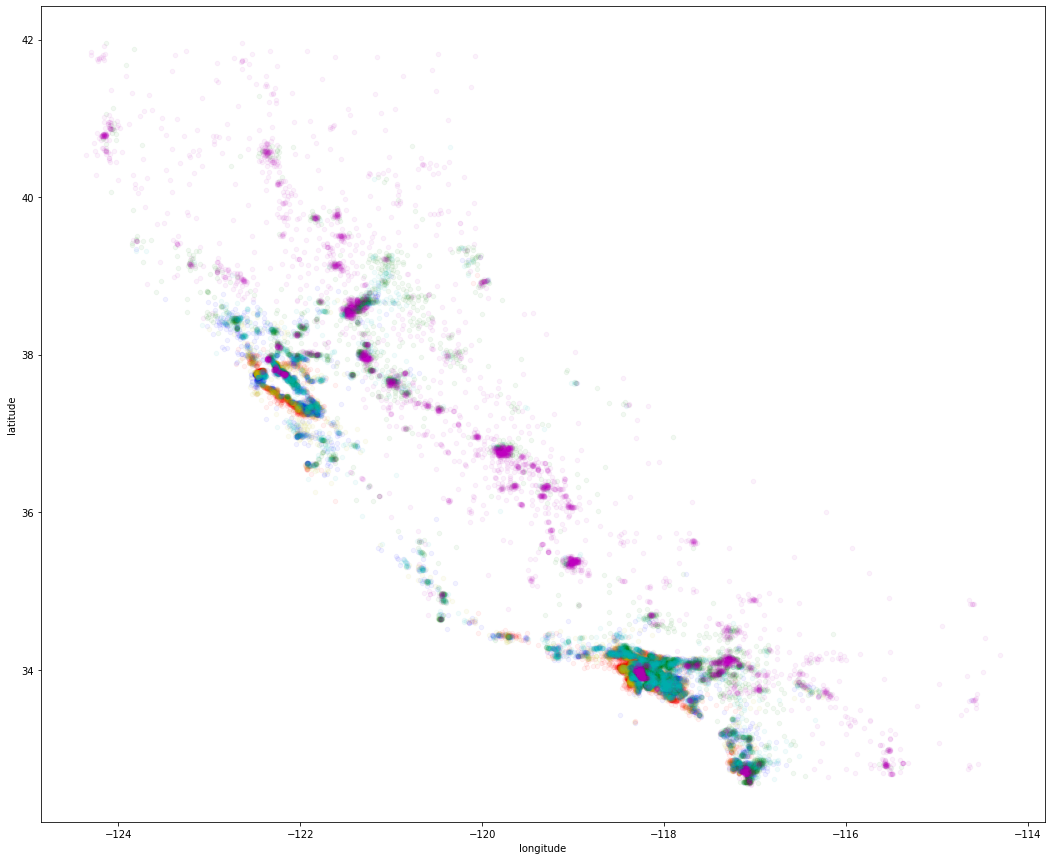

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 6, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  760917360487.1282
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.531829  35.272146           28.534986  2830.422655      575.094446   
std     1.947389   1.880531           12.246127  2314.098713      443.638135   

       population  households  median_income  median_house_value  
mean  1511.781613  543.269532       4.151153       227647.913398  
std   1141.264460  405.770825       1.223738        15225.386769  

Cluster 2 : 
SSE (Cumulative):  884420524043.5635
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.726330  35.267879           33.334441  2961.365691      514.714761   
std     1.967937   1.810265           13.088998  2165.329750      385.206088   

       population  households  median_income  median_house_value  
mean  1155.813830  480.690160       7.104367       484959.750665  
std    849.455647  353.862876       3.063544        24140.273212  

Cluster 3 : 
SS

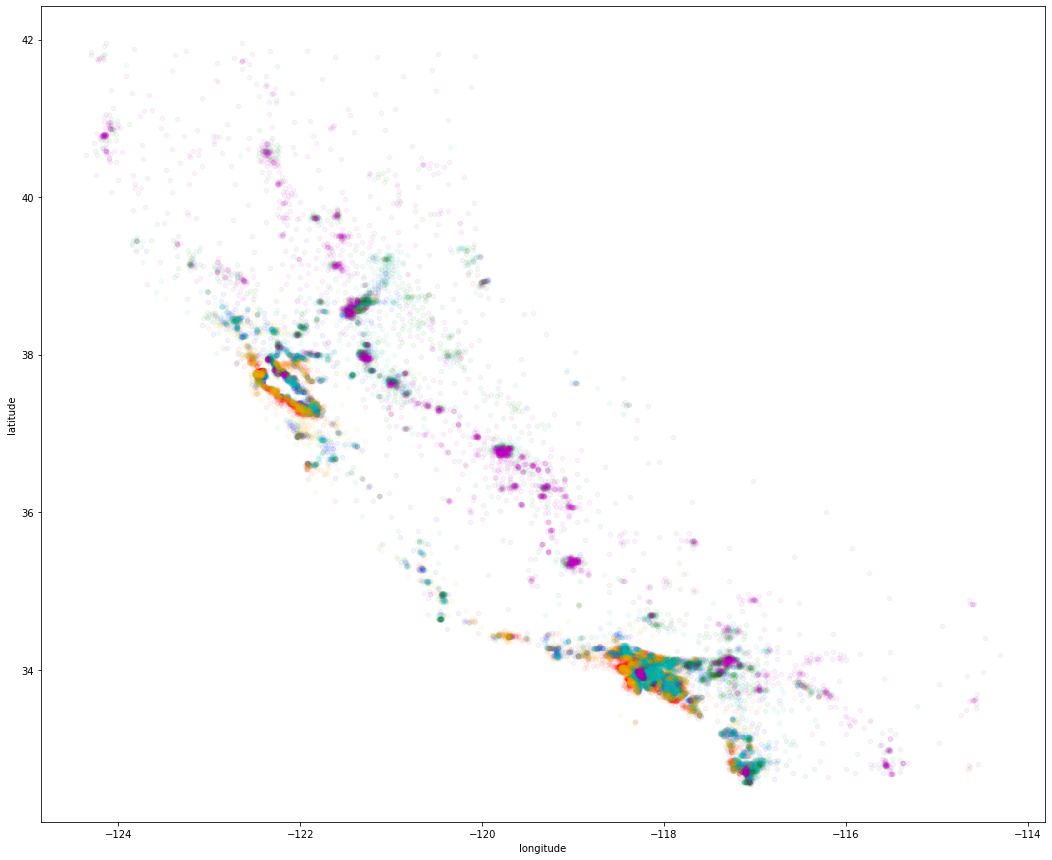

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 7, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  601846923696.2195
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.585120  35.304681           28.732846  2870.608499      577.385928   
std     1.965699   1.880634           12.353674  2424.997771      459.352187   

       population  households  median_income  median_house_value  
mean  1509.682341  545.202020       4.214337       233863.462208  
std   1156.861243  417.164859       1.258677        14216.139638  

Cluster 2 : 
SSE (Cumulative):  805262863312.4893
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.722530  35.265418           33.406208  2959.018893      513.506073   
std     1.969091   1.810870           13.066739  2172.281700      386.614921   

       population  households  median_income  median_house_value  
mean  1153.296221  479.147099       7.130024       485843.228745  
std    851.805947  354.733834       3.063130        23195.026818  

Cluster 3 : 
SS

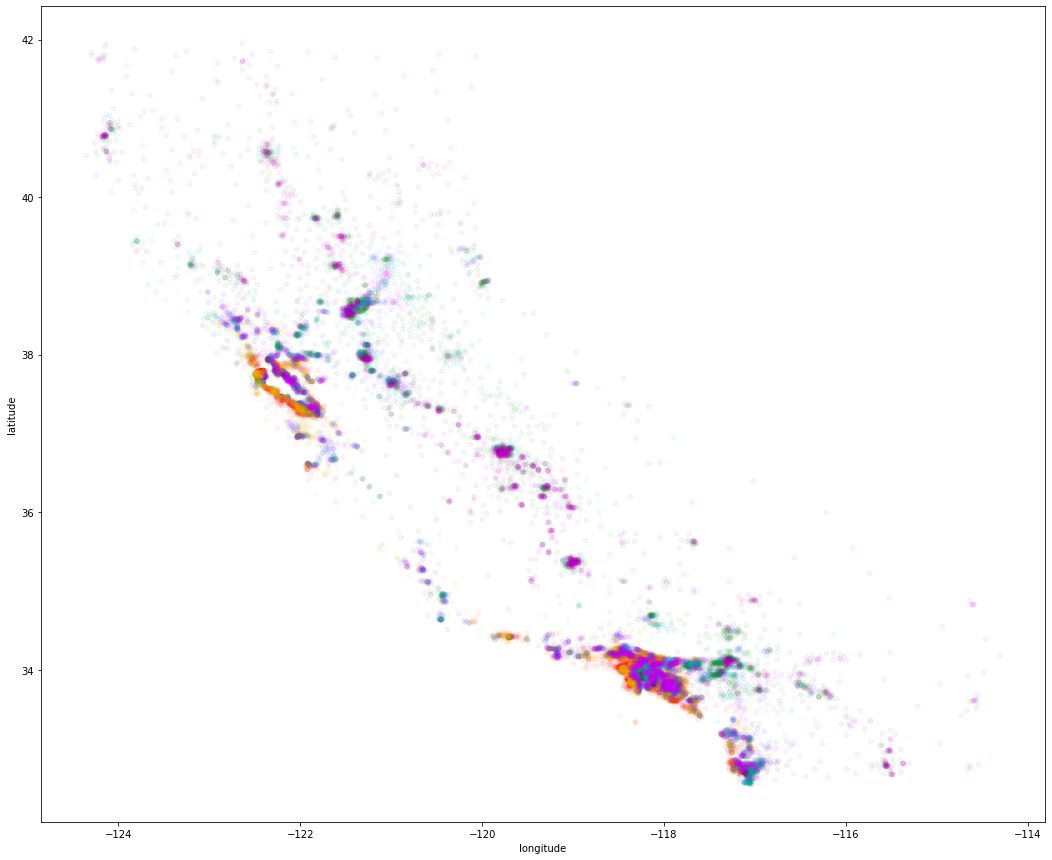

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 8, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  462723680565.8009
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.871910  35.488469           28.175062  3083.665835      595.398005   
std     2.058421   1.915687           12.805382  2364.399452      460.686356   

       population  households  median_income  median_house_value  
mean  1499.838404  564.753117       4.696680       276843.940150  
std   1135.314543  427.775371       1.396632        14954.107088  

Cluster 2 : 
SSE (Cumulative):  294074913145.8896
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.701917  35.234668           33.467543  2957.166151      511.246522   
std     1.965902   1.799999           13.077618  2242.257810      397.939418   

       population  households  median_income  median_house_value  
mean  1141.571097  475.718702       7.308685       492872.074961  
std    872.602918  363.888456       3.162199        14878.037944  

Cluster 3 : 
SS

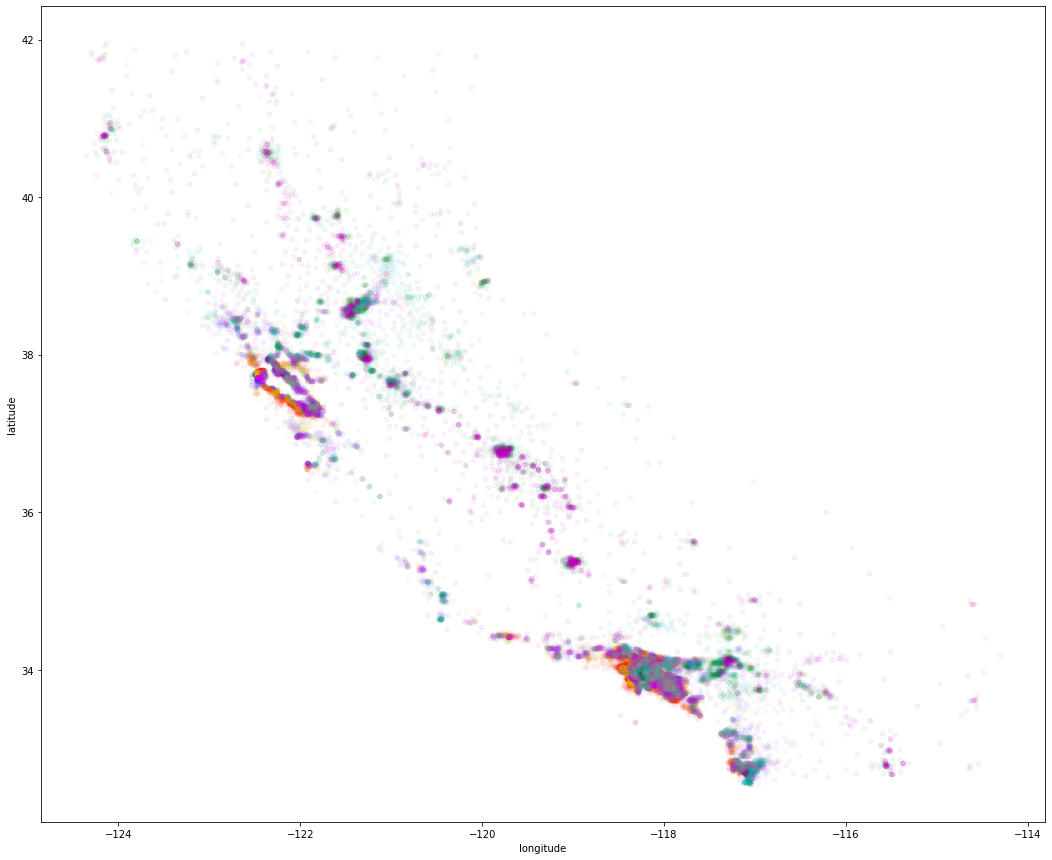

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 9, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

Cluster 1 :
SSE (Cumulative):  399413773503.6886
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.563896  35.289619           28.622152  2863.789866      578.417518   
std     1.956915   1.879058           12.306347  2429.424173      460.747819   

       population  households  median_income  median_house_value  
mean  1514.107227  545.891202       4.195437       232038.609584  
std   1166.900767  419.518440       1.252855        12218.362211  

Cluster 2 : 
SSE (Cumulative):  294074913145.8896
       longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
mean -119.701917  35.234668           33.467543  2957.166151      511.246522   
std     1.965902   1.799999           13.077618  2242.257810      397.939418   

       population  households  median_income  median_house_value  
mean  1141.571097  475.718702       7.308685       492872.074961  
std    872.602918  363.888456       3.162199        14878.037944  

Cluster 3 : 
SS

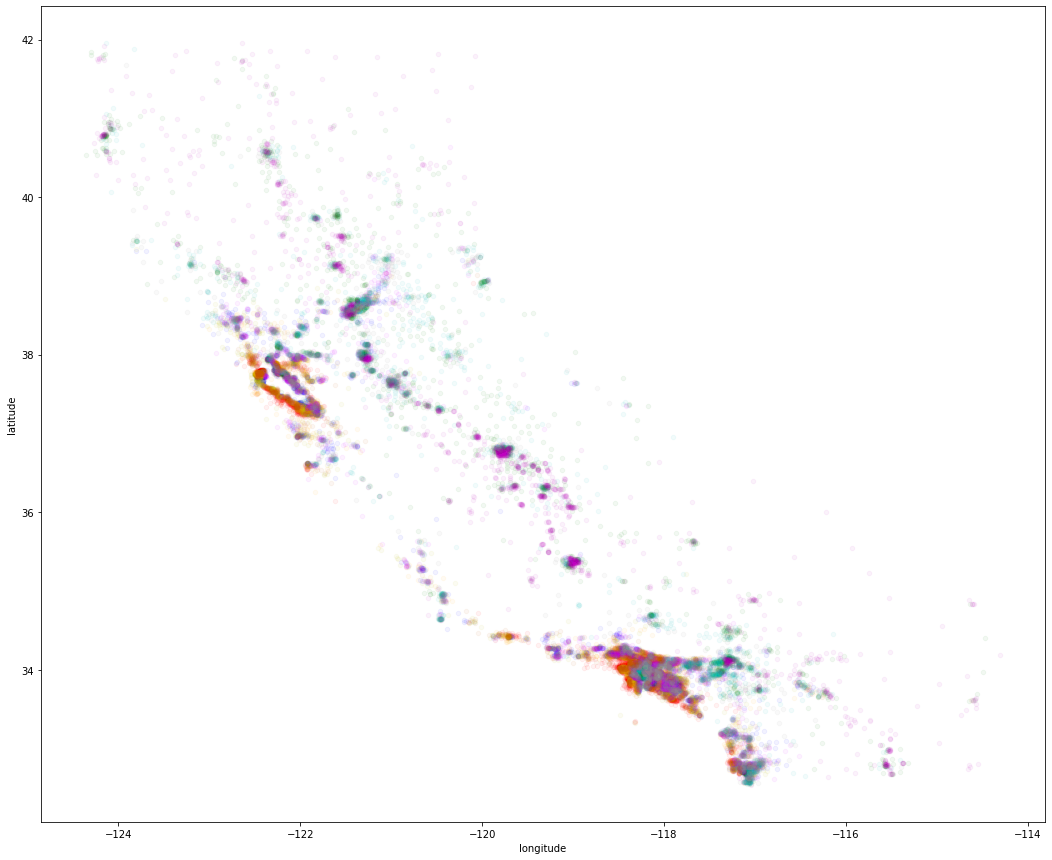

In [ ]:
random.seed(42)

#plt.figure(figsize=(16, 12))
centroids, clusters = k_means(X, 10, EUCLIDEAN, tolerance=.75);
firstCumSum = cumulative_SSE(centroids[0], clusters[0]);
rebuiltDF = pd.DataFrame(np.row_stack(clusters[0]));
rebuiltDF.columns=num_attribs;
ax = rebuiltDF.plot(kind="scatter", x='longitude', y='latitude', color=colors[0], alpha=0.05, figsize=(18, 15))
print("Cluster 1 :")
print("SSE (Cumulative): ", firstCumSum);
print(rebuiltDF.describe().loc[['mean', 'std']]);

for i in range(1, len(centroids)):
  cSum = cumulative_SSE(centroids[i], clusters[i]);
  DF = pd.DataFrame(np.row_stack(clusters[i]));
  DF.columns=num_attribs;
  print("\nCluster", i+1, ": ");
  print("SSE (Cumulative): ", cSum);
  print(DF.describe().loc[['mean', 'std']]);
  DF.plot(kind="scatter", x=0, y=1, ax=ax, color=colors[i], alpha=0.05)

As can be seen, we can separate the data into somewhat distinct sections of California. The Bay Area can be clearly seen even in this sparse view - as well as the developed area south of it that is Silicon Valley, the red-and-yellow cluster that is distinguished from the comparatively older cyan-and-purple cluster that is San Francisco proper. 

As the number of clusters increase, the clusters themselves become more differentiated and specialized based on their attributes. This differentiation can be most easily seen in each cluster's average median house value, with different clusters occupying different strata of cost. 

Each cluster doesn't seem to be well-separated from the others, however - and that can be attributed to the high number of features we did use: all 9 quantitative features. This may introduce somewhat irrelevant features such as number of bedrooms or population, causing unwanted overlap of clusters. If we were to limit the number of features considered to mere geographic location and cost, we can expect a higher number of clusters that are well-differentiated geographically and economically. 

Lastly, this attempt at clustering can be considered a success. While using lists instead of numpy arrays is probably inadvisable, the algorithm is somewhat easier to interpret and understand when using such an approach. Our k-means clustering process successfully differentiated the data based upon the 9 quantitative attributes in order for us to draw meaningful conclusions about the housing situation in California.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



The California housing crisis is an ongoing situation where individuals and families find themselves unable to afford housing in California. This can be (and has been) attributed to a number of factors such as the presence of tech companies (and subsequent gentrification), the stark contrast in established infrastructure between urban and rural California, and the unavailability of land to build more houses due to zoning restrictions. The most prominent example, of course, being San Francisco, Silicon Valley, and the rest of the Bay Area. As demonstrated by the graphs and the analyses above, the footprint of large technology companies causes regional housing prices to skyrocket. And, as also demonstrated by the graphs, urbanization also significantly increases prices simply due to location. 

A significant factor of this crisis that has been often discussed is the scarcity of housing - rural California is hardly developed and urban and suburban expansion run into a California-unique problem: that of zoning restrictions. California (until a few weeks ago) had zoning restrictions that mandated that only *one* housing unit be built on a given parcel of land. A whopping **75%** of California's *total developable land* is zoned as such. This amount of developable land is why, on the graph, most points are clustered towards the coast and not further inland, where there is often minimal infrastructure. This causes a large amount of scarcity since development cannot be nearly as dense as other urban areas around the country - and thus substantially drives up the price. 

Thankfully, these restrictions have since been rescinded, leaving us with the ubiquitous but somewhat less impactful aspect of gentrification due to the tech companies' presence. A common solution to gentification is that of building affordable housing projects, which can be now built more easily due to the loosening of zoning restrictions. If this is accomplished (and should soon be due to the notoriety of California's urban homeless problem), then the housing crisis can be mitigated and possibly abated.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!